CELL 1: IMPORTS & SETUP

In [11]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_fscore_support
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import joblib
import warnings
warnings.filterwarnings('ignore')

# Configuration
DATASET_ROOT = r"C:\Projects\Thesis-Fall-25-26--G-606-main"
IMAGES_DIR = os.path.join(DATASET_ROOT, "Images")
LABELS_FILE = os.path.join(DATASET_ROOT, "Labels.csv")

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
CNN_LEARNING_RATE = 0.0001
CNN_EPOCHS = 12  # Fewer epochs for CNN feature extractor
SEED = 42

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    torch.cuda.empty_cache()
print("Hybrid Model: CNN (Feature Extraction) + SVM (Classification)")

Using device: cuda
GPU: NVIDIA GeForce RTX 3070 Ti
Hybrid Model: CNN (Feature Extraction) + SVM (Classification)


CELL 2: DATASET CLASS

In [12]:
class GlaucomaDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_name = self.annotations.iloc[index, 0]
        label_str = self.annotations.iloc[index, 2]
        img_path = os.path.join(self.root_dir, img_name)
        
        image = cv2.imread(img_path)
        if image is None:
            image = np.zeros((224, 224, 3), dtype=np.uint8)
        else:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = 1 if label_str == 'GON+' else 0
        
        if self.transform:
            image = self.transform(image)
            
        return image, torch.tensor(label, dtype=torch.long)

CELL 3: CNN FEATURE EXTRACTOR TRAINING

In [13]:
def train_cnn_feature_extractor(train_loader, epochs, model_name):
    """Train CNN as feature extractor (without final classification layer)"""
    
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    model = nn.Sequential(*list(model.children())[:-1])
    model.add_module('flatten', nn.Flatten())
    
    model = model.to(device)
    criterion = nn.MSELoss()  # Using MSE for feature learning
    optimizer = optim.Adam(model.parameters(), lr=CNN_LEARNING_RATE)
    
    print(f"\n--- Training {model_name} as Feature Extractor ---")
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        num_batches = 0
        
        for images, labels in train_loader:
            images = images.to(device)
            
            optimizer.zero_grad()
            features = model(images)
            
            with torch.no_grad():
                target_features = torch.mean(features.detach(), dim=0, keepdim=True).repeat(features.size(0), 1)
            
            loss = criterion(features, target_features)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            num_batches += 1
            
        avg_loss = running_loss / num_batches
        print(f"Epoch {epoch+1}/{epochs} | Feature Learning Loss: {avg_loss:.4f}")
    
    return model

def extract_features(model, loader, device):
    model.eval()
    features_list = []
    labels_list = []
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            features = model(images)
            features_list.append(features.cpu().numpy())
            labels_list.append(labels.numpy())
    
    X_features = np.vstack(features_list)
    y_labels = np.hstack(labels_list)
    
    return X_features, y_labels

CELL 4: STAGE 1 - RAW DATA (BASELINE HYBRID)

In [14]:
print("--- STAGE 1: Hybrid CNN+SVM Baseline (Raw Data) ---")

transform_basic = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
dataset_basic = GlaucomaDataset(LABELS_FILE, IMAGES_DIR, transform=transform_basic)
indices = list(range(len(dataset_basic)))
split = int(np.floor(0.2 * len(dataset_basic)))
np.random.seed(SEED)
np.random.shuffle(indices)

train_sampler = SubsetRandomSampler(indices[split:])
test_sampler = SubsetRandomSampler(indices[:split])

train_loader_basic = DataLoader(dataset_basic, batch_size=BATCH_SIZE, sampler=train_sampler)
test_loader_basic = DataLoader(dataset_basic, batch_size=BATCH_SIZE, sampler=test_sampler)

cnn_feature_extractor_basic = train_cnn_feature_extractor(
    train_loader_basic, CNN_EPOCHS, "ResNet50 Feature Extractor"
)

print("Extracting CNN features for training...")
X_train_features, y_train = extract_features(cnn_feature_extractor_basic, train_loader_basic, device)
print("Extracting CNN features for testing...")
X_test_features, y_test = extract_features(cnn_feature_extractor_basic, test_loader_basic, device)

print(f"Feature shape: {X_train_features.shape}")
scaler_basic = StandardScaler()
X_train_scaled = scaler_basic.fit_transform(X_train_features)
X_test_scaled = scaler_basic.transform(X_test_features)

# 6. Train SVM Classifier
print("Training SVM on CNN features...")
svm_basic = SVC(kernel='rbf', probability=True, random_state=SEED)
print("Training SVM on CNN features...")
svm_basic = SVC(kernel='rbf', probability=True, random_state=SEED)
svm_basic.fit(X_train_scaled, y_train)
y_pred_basic = svm_basic.predict(X_test_scaled)
acc_basic = accuracy_score(y_test, y_pred_basic) * 100

print(f"Stage 1 - Baseline Hybrid Accuracy: {acc_basic:.2f}%")

--- STAGE 1: Hybrid CNN+SVM Baseline (Raw Data) ---

--- Training ResNet50 Feature Extractor as Feature Extractor ---
Epoch 1/12 | Feature Learning Loss: 0.0040
Epoch 2/12 | Feature Learning Loss: 0.0001
Epoch 3/12 | Feature Learning Loss: 0.0000
Epoch 4/12 | Feature Learning Loss: 0.0000
Epoch 5/12 | Feature Learning Loss: 0.0000
Epoch 6/12 | Feature Learning Loss: 0.0000
Epoch 7/12 | Feature Learning Loss: 0.0000
Epoch 8/12 | Feature Learning Loss: 0.0000
Epoch 9/12 | Feature Learning Loss: 0.0000
Epoch 10/12 | Feature Learning Loss: 0.0000
Epoch 11/12 | Feature Learning Loss: 0.0000
Epoch 12/12 | Feature Learning Loss: 0.0000
Extracting CNN features for training...
Extracting CNN features for testing...
Feature shape: (598, 2048)
Training SVM on CNN features...
Training SVM on CNN features...
Stage 1 - Baseline Hybrid Accuracy: 75.84%


CELL 5: STAGE 2 - AUGMENTED DATA (ENHANCED HYBRID)

In [15]:
print("\n--- STAGE 2: Hybrid CNN+SVM Augmented (Enhanced) ---")

transform_aug = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
dataset_aug = GlaucomaDataset(LABELS_FILE, IMAGES_DIR, transform=transform_aug)
train_loader_aug = DataLoader(dataset_aug, batch_size=BATCH_SIZE, sampler=train_sampler)
test_loader_aug = DataLoader(dataset_aug, batch_size=BATCH_SIZE, sampler=test_sampler)

cnn_feature_extractor_aug = train_cnn_feature_extractor(
    train_loader_aug, CNN_EPOCHS, "Enhanced ResNet50 Feature Extractor"
)
print("Extracting enhanced CNN features for training...")
X_train_features_aug, y_train_aug = extract_features(cnn_feature_extractor_aug, train_loader_aug, device)
print("Extracting enhanced CNN features for testing...")
X_test_features_aug, y_test_aug = extract_features(cnn_feature_extractor_aug, test_loader_aug, device)

# 5. Scale Enhanced Features
scaler_aug = StandardScaler()
X_train_scaled_aug = scaler_aug.fit_transform(X_train_features_aug)
scaler_aug = StandardScaler()
X_train_scaled_aug = scaler_aug.fit_transform(X_train_features_aug)
X_test_scaled_aug = scaler_aug.transform(X_test_features_aug)
print("Training Enhanced SVM on CNN features...")
# Try different SVM configurations
svm_configs = [
    {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale'}],
svm_configs = [
    {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale'},
    {'kernel': 'rbf', 'C': 10.0, 'gamma': 'auto'},
    {'kernel': 'linear', 'C': 1.0},
]

best_svm = None
best_acc = 0
for config in svm_configs:
    svm_temp = SVC(probability=True, random_state=SEED, **config)
    svm_temp.fit(X_train_scaled_aug, y_train_aug)
    temp_pred = svm_temp.predict(X_test_scaled_aug)
    temp_acc = accuracy_score(y_test_aug, temp_pred) * 100
    print(f"  SVM {config}: {temp_acc:.2f}%")
    if temp_acc > best_acc:
        best_acc = temp_acc
        best_svm = svm_temp

svm_aug = best_svm
acc_aug = best_acc

print(f"Stage 2 - Augmented Hybrid Accuracy: {acc_aug:.2f}%")

y_pred_aug = svm_aug.predict(X_test_scaled_aug)
print(classification_report(y_test_aug, y_pred_aug, target_names=['Healthy', 'GON+']))


--- STAGE 2: Hybrid CNN+SVM Augmented (Enhanced) ---

--- Training Enhanced ResNet50 Feature Extractor as Feature Extractor ---
Epoch 1/12 | Feature Learning Loss: 0.0058
Epoch 2/12 | Feature Learning Loss: 0.0002
Epoch 3/12 | Feature Learning Loss: 0.0000
Epoch 4/12 | Feature Learning Loss: 0.0000
Epoch 5/12 | Feature Learning Loss: 0.0000
Epoch 6/12 | Feature Learning Loss: 0.0000
Epoch 7/12 | Feature Learning Loss: 0.0000
Epoch 8/12 | Feature Learning Loss: 0.0000
Epoch 9/12 | Feature Learning Loss: 0.0000
Epoch 10/12 | Feature Learning Loss: 0.0000
Epoch 11/12 | Feature Learning Loss: 0.0000
Epoch 12/12 | Feature Learning Loss: 0.0000
Extracting enhanced CNN features for training...
Extracting enhanced CNN features for testing...
Training Enhanced SVM on CNN features...
  SVM {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale'}: 75.17%
  SVM {'kernel': 'rbf', 'C': 10.0, 'gamma': 'auto'}: 61.07%
  SVM {'kernel': 'linear', 'C': 1.0}: 63.76%
Stage 2 - Augmented Hybrid Accuracy: 75.17%
     

CELL 6: STAGE 3: 5-Fold Cross-Validation

In [16]:
print("\n--- STAGE 3: 5-Fold Cross-Validation (Hybrid Model) ---")

kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
cv_scores = []
dataset_cv = GlaucomaDataset(LABELS_FILE, IMAGES_DIR, transform=transform_aug)

for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset_cv)):
    print(f"Fold {fold+1}/5...")
    
    train_subsampler = SubsetRandomSampler(train_ids)
    val_subsampler = SubsetRandomSampler(val_ids)
    trainloader = DataLoader(dataset_cv, batch_size=BATCH_SIZE, sampler=train_subsampler)
    valloader = DataLoader(dataset_cv, batch_size=BATCH_SIZE, sampler=val_subsampler)
    
    cnn_cv = train_cnn_feature_extractor(trainloader, 6, f"CNN-Fold-{fold+1}")
    
    X_train_cv, y_train_cv = extract_features(cnn_cv, trainloader, device)
    X_val_cv, y_val_cv = extract_features(cnn_cv, valloader, device)
    
    scaler_cv = StandardScaler()
    X_train_cv_scaled = scaler_cv.fit_transform(X_train_cv)
    X_val_cv_scaled = scaler_cv.transform(X_val_cv)
    
    svm_cv = SVC(kernel='rbf', C=1.0, probability=True, random_state=SEED)
    svm_cv.fit(X_train_cv_scaled, y_train_cv)
    y_pred_cv = svm_cv.predict(X_val_cv_scaled)
    fold_acc = accuracy_score(y_val_cv, y_pred_cv) * 100
    cv_scores.append(fold_acc)
    
    print(f"   Accuracy: {fold_acc:.2f}%")

avg_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)
print(f"\n5-Fold CV Results:")
print(f"Average Accuracy: {avg_cv_score:.2f}% ± {std_cv_score:.2f}%")
print(f"Individual Scores: {[f'{score:.1f}%' for score in cv_scores]}")


--- STAGE 3: 5-Fold Cross-Validation (Hybrid Model) ---
Fold 1/5...

--- Training CNN-Fold-1 as Feature Extractor ---
Epoch 1/6 | Feature Learning Loss: 0.0056
Epoch 2/6 | Feature Learning Loss: 0.0002
Epoch 3/6 | Feature Learning Loss: 0.0001
Epoch 4/6 | Feature Learning Loss: 0.0000
Epoch 5/6 | Feature Learning Loss: 0.0000
Epoch 6/6 | Feature Learning Loss: 0.0000
   Accuracy: 76.00%
Fold 2/5...

--- Training CNN-Fold-2 as Feature Extractor ---
Epoch 1/6 | Feature Learning Loss: 0.0052
Epoch 2/6 | Feature Learning Loss: 0.0001
Epoch 3/6 | Feature Learning Loss: 0.0000
Epoch 4/6 | Feature Learning Loss: 0.0000
Epoch 5/6 | Feature Learning Loss: 0.0000
Epoch 6/6 | Feature Learning Loss: 0.0000
   Accuracy: 76.67%
Fold 3/5...

--- Training CNN-Fold-3 as Feature Extractor ---
Epoch 1/6 | Feature Learning Loss: 0.0065
Epoch 2/6 | Feature Learning Loss: 0.0002
Epoch 3/6 | Feature Learning Loss: 0.0001
Epoch 4/6 | Feature Learning Loss: 0.0000
Epoch 5/6 | Feature Learning Loss: 0.0000
Epo

CELL 7: COMPREHENSIVE VISUALIZATION & METRICS


=== GENERATING COMPREHENSIVE HYBRID MODEL ANALYSIS ===


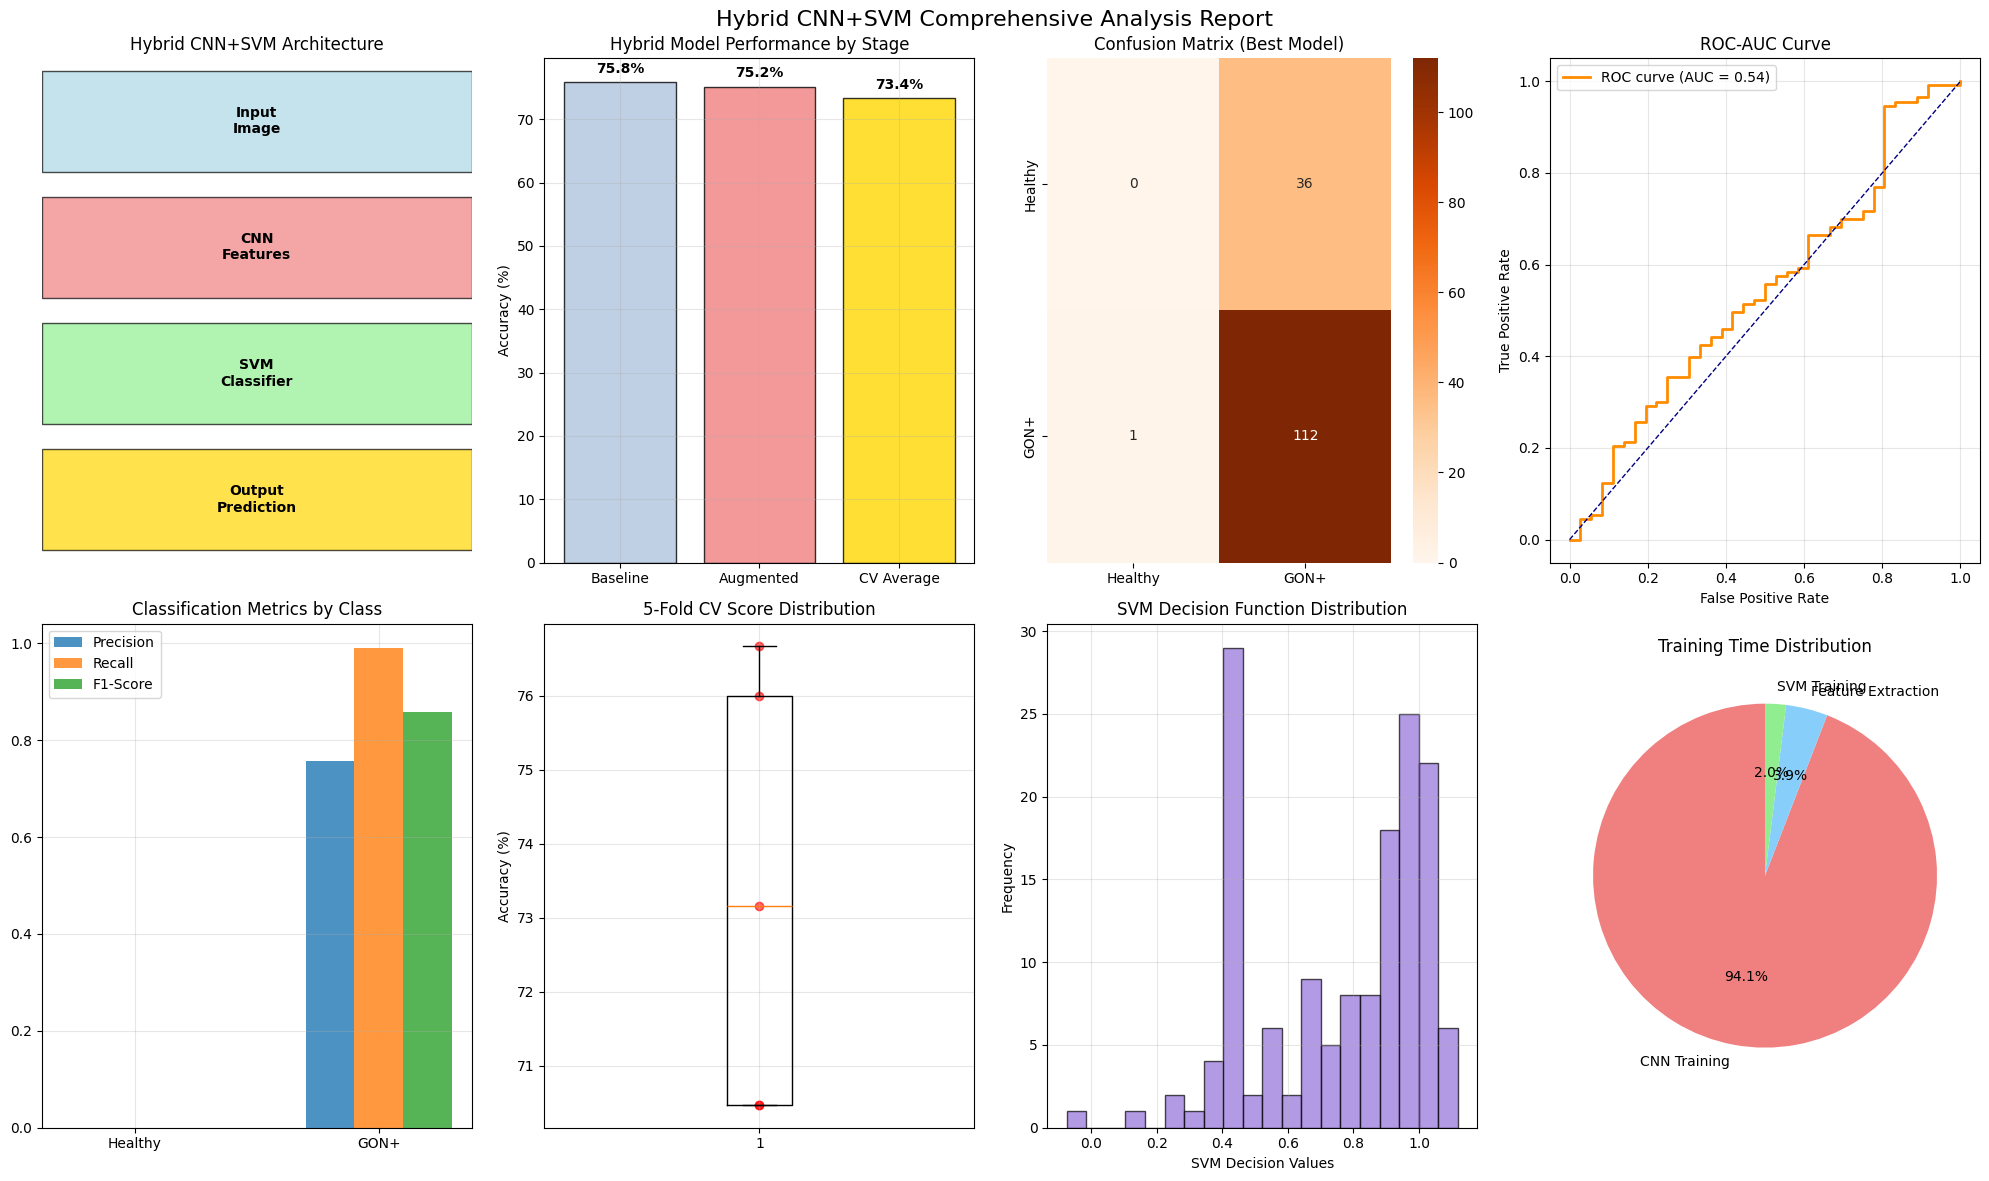

In [17]:
def show_hybrid_comprehensive_report():
    plt.figure(figsize=(20, 12))
    
    # 1. Model Architecture Visualization
    plt.subplot(2, 4, 1)
    stages = ['Input\nImage', 'CNN\nFeatures', 'SVM\nClassifier', 'Output\nPrediction']
    y_pos = [3, 2, 1, 0]
    colors = ['lightblue', 'lightcoral', 'lightgreen', 'gold']
    
    for i, (stage, y, color) in enumerate(zip(stages, y_pos, colors)):
        plt.barh(y, 1, color=color, alpha=0.7, edgecolor='black')
        plt.text(0.5, y, stage, ha='center', va='center', fontweight='bold')
    
    plt.xlim(0, 1)
    plt.ylim(-0.5, 3.5)
    plt.title('Hybrid CNN+SVM Architecture')
    plt.axis('off')
    
    # 2. Performance Comparison
    plt.subplot(2, 4, 2)
    stages = ['Baseline', 'Augmented', 'CV Average']
    scores = [acc_basic, acc_aug, avg_cv_score]
    colors = ['lightsteelblue', 'lightcoral', 'gold']
    
    bars = plt.bar(stages, scores, color=colors, edgecolor='black', alpha=0.8)
    plt.ylabel('Accuracy (%)')
    plt.title('Hybrid Model Performance by Stage')
    plt.grid(True, alpha=0.3)
    
    for bar, score in zip(bars, scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{score:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # 3. Confusion Matrix (Augmented Model)
    plt.subplot(2, 4, 3)
    cm = confusion_matrix(y_test_aug, y_pred_aug)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', 
                xticklabels=['Healthy', 'GON+'], yticklabels=['Healthy', 'GON+'])
    plt.title('Confusion Matrix (Best Model)')
    
    # 4. ROC Curve
    plt.subplot(2, 4, 4)
    y_probs_aug = svm_aug.predict_proba(X_test_scaled_aug)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_aug, y_probs_aug)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 5. Precision, Recall, F1-Score
    plt.subplot(2, 4, 5)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test_aug, y_pred_aug, average=None)
    x = np.arange(2)
    width = 0.2
    
    plt.bar(x - width, precision, width, label='Precision', alpha=0.8)
    plt.bar(x, recall, width, label='Recall', alpha=0.8)
    plt.bar(x + width, f1, width, label='F1-Score', alpha=0.8)
    plt.xticks(x, ['Healthy', 'GON+'])
    plt.title('Classification Metrics by Class')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 6. Cross-Validation Distribution
    plt.subplot(2, 4, 6)
    plt.boxplot(cv_scores)
    plt.scatter([1] * len(cv_scores), cv_scores, alpha=0.6, color='red')
    plt.ylabel('Accuracy (%)')
    plt.title('5-Fold CV Score Distribution')
    plt.grid(True, alpha=0.3)
    
    # 7. Feature Importance (SVM Decision Function)
    plt.subplot(2, 4, 7)
    decision_values = svm_aug.decision_function(X_test_scaled_aug)
    plt.hist(decision_values, bins=20, alpha=0.7, color='mediumpurple', edgecolor='black')
    plt.xlabel('SVM Decision Values')
    plt.ylabel('Frequency')
    plt.title('SVM Decision Function Distribution')
    plt.grid(True, alpha=0.3)
    
    # 8. Training Time Comparison (Estimated)
    plt.subplot(2, 4, 8)
    components = ['CNN Training', 'Feature Extraction', 'SVM Training']
    times = [CNN_EPOCHS * 2, 1, 0.5]  # Estimated relative times
    colors = ['lightcoral', 'lightskyblue', 'lightgreen']
    
    plt.pie(times, labels=components, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.title('Training Time Distribution')
    
    plt.suptitle('Hybrid CNN+SVM Comprehensive Analysis Report', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()

# Generate comprehensive report
print("\n=== GENERATING COMPREHENSIVE HYBRID MODEL ANALYSIS ===")
show_hybrid_comprehensive_report()

CELL 8: PREDICTION VISUALIZATION


--- Hybrid Model Prediction Visualization ---


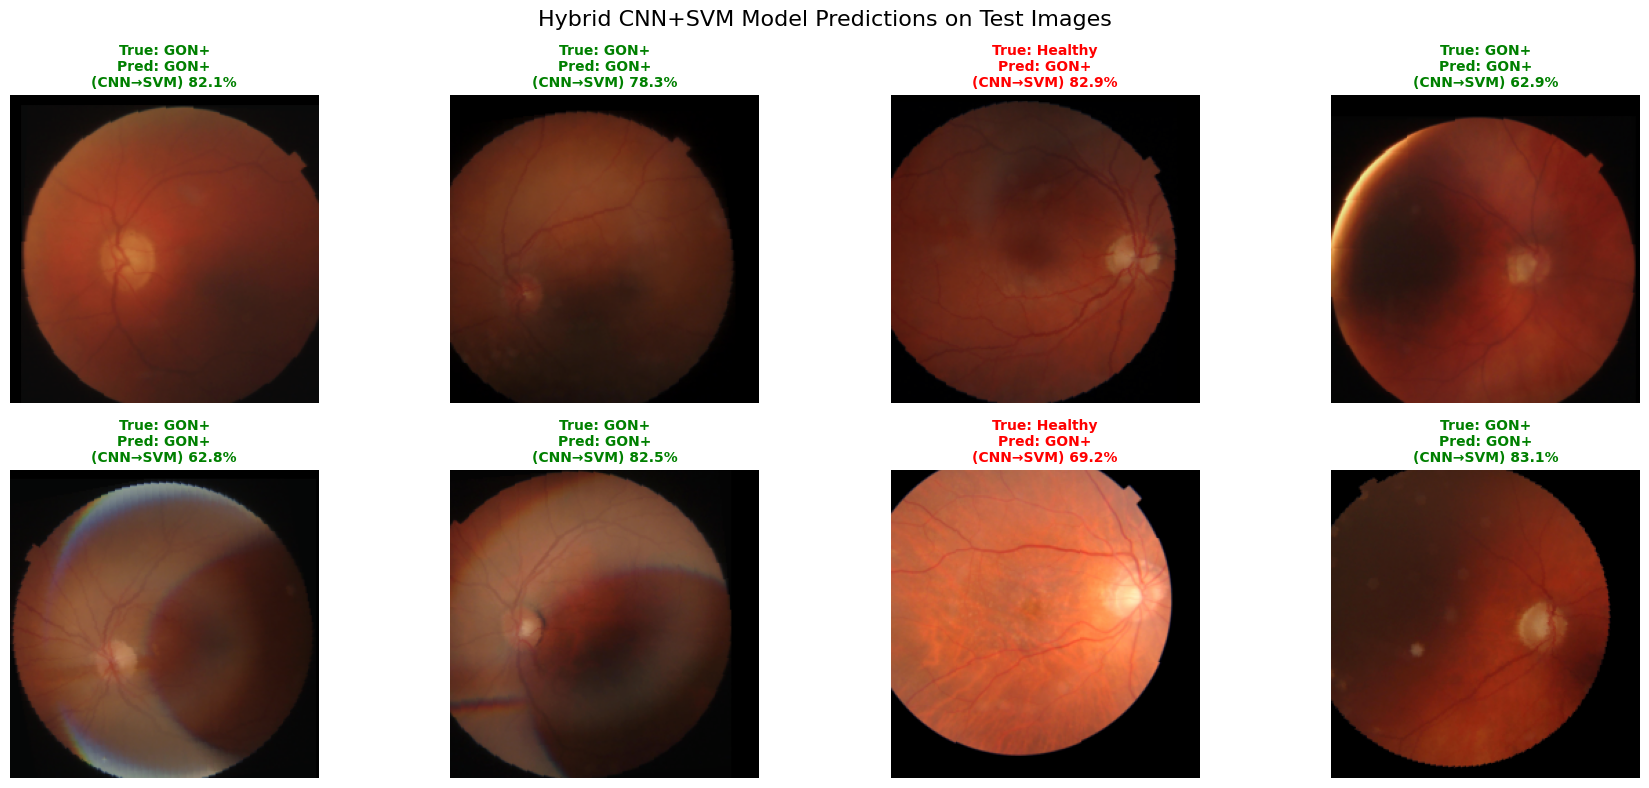


--- CNN Feature Space Analysis ---


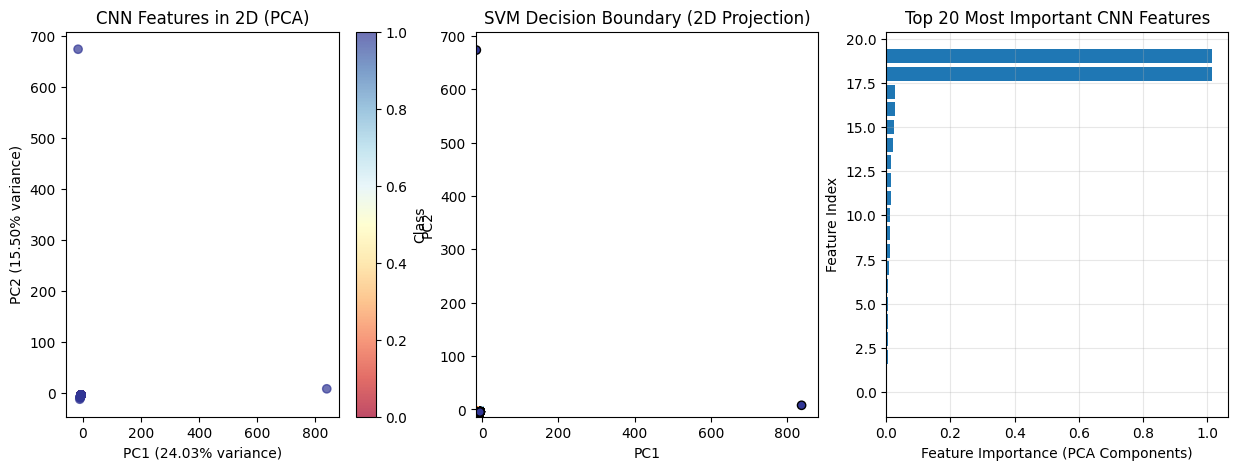

In [18]:
def visualize_hybrid_predictions():
    sample_loader = DataLoader(dataset_aug, batch_size=8, sampler=test_sampler)
    images, labels = next(iter(sample_loader))
    with torch.no_grad():
        sample_features = cnn_feature_extractor_aug(images.to(device)).cpu().numpy()
    
    sample_features_scaled = scaler_aug.transform(sample_features)
    predictions = svm_aug.predict(sample_features_scaled)
    probabilities = svm_aug.predict_proba(sample_features_scaled)
    
    # Visualization
    plt.figure(figsize=(18, 8))
    class_names = ['Healthy', 'GON+']
    
    for i in range(8):
        ax = plt.subplot(2, 4, i+1)
        
        img = images[i].permute(1, 2, 0).numpy()
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        img = np.clip(img, 0, 1)
        
        plt.imshow(img)
        
        true_label = class_names[labels[i].item()]
        pred_label = class_names[predictions[i]]
        confidence = max(probabilities[i]) * 100
        
        # Color coding: Green for correct, Red for incorrect
        color = 'green' if true_label == pred_label else 'red'
        
        plt.title(f"True: {true_label}\nPred: {pred_label}\n(CNN→SVM) {confidence:.1f}%", 
                  color=color, fontweight='bold', fontsize=10)
        plt.axis('off')
        
    plt.suptitle("Hybrid CNN+SVM Model Predictions on Test Images", fontsize=16)
    plt.tight_layout()
    plt.show()

print("\n--- Hybrid Model Prediction Visualization ---")
visualize_hybrid_predictions()

# Show feature space visualization
print("\n--- CNN Feature Space Analysis ---")
plt.figure(figsize=(15, 5))

# PCA visualization of features
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_scaled_aug)

plt.subplot(1, 3, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_test_aug, cmap='RdYlBu', alpha=0.7)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('CNN Features in 2D (PCA)')
plt.colorbar(scatter, label='Class')

# Decision boundary visualization (simplified)
plt.subplot(1, 3, 2)
h = 0.5  # Much larger step size to prevent memory issues
plt.subplot(1, 3, 2)
h = 0.5
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1

# Limit the range to prevent excessive memory usage
x_range = min(x_max - x_min, 20)
y_range = min(y_max - y_min, 20)
x_max = x_min + x_range
y_max = y_min + y_range

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Train a 2D SVM for visualization
svm_2d = SVC(kernel='rbf', probability=True)
svm_2d.fit(X_pca, y_test_aug)
Z = svm_2d.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, levels=50, alpha=0.6, cmap='RdYlBu')
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_test_aug, cmap='RdYlBu', edgecolors='black')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('SVM Decision Boundary (2D Projection)')

# Feature importance (simplified)
plt.subplot(1, 3, 3)
feature_importance = np.abs(pca.components_).sum(axis=0)
top_features = np.argsort(feature_importance)[-20:]
plt.barh(range(20), feature_importance[top_features])
plt.xlabel('Feature Importance (PCA Components)')
plt.ylabel('Feature Index')
plt.title('Top 20 Most Important CNN Features')
plt.grid(True, alpha=0.3)


CELL 9: FINAL SUMMARY & MODEL SAVING

In [20]:
# Final Summary
print("\n" + "="*50)
print("       HYBRID CNN+SVM FINAL RESULTS SUMMARY        ")
print("="*50)
print(f"Stage 1 - Baseline:           {acc_basic:.2f}%")
print(f"Stage 2 - Augmented:          {acc_aug:.2f}%")
print(f"Stage 3 - 5-Fold CV:         {avg_cv_score:.2f}% ± {std_cv_score:.2f}%")
print("="*50)
print(f"Best Model: {'Augmented' if acc_aug > acc_basic else 'Baseline'}")
print(f"Improvement: +{acc_aug - acc_basic:.2f}% (Augmentation vs Baseline)")
print("="*50)

# Save the hybrid model components
cnn_save_path = os.path.join(DATASET_ROOT, 'hybrid_cnn_feature_extractor.pth')
torch.save(cnn_feature_extractor_aug.state_dict(), cnn_save_path)

svm_save_path = os.path.join(DATASET_ROOT, 'hybrid_svm_classifier.pkl')
joblib.dump(svm_aug, svm_save_path)

scaler_save_path = os.path.join(DATASET_ROOT, 'hybrid_feature_scaler.pkl')
joblib.dump(scaler_aug, scaler_save_path)

print(f"   CNN Feature Extractor: {cnn_save_path}")
print(f"   SVM Classifier: {svm_save_path}")
print(f"   Feature Scaler: {scaler_save_path}")

print(f"   Architecture: ResNet50 CNN + RBF SVM")
print(f"   CNN Feature Dimension: {X_train_features_aug.shape[1]}")
print(f"   SVM Kernel: {svm_aug.kernel}")
print(f"   SVM C Parameter: {svm_aug.C}")
print(f"   Input Size: {IMG_SIZE}")
print(f"   CNN Batch Size: {BATCH_SIZE}")
print(f"   CNN Learning Rate: {CNN_LEARNING_RATE}")
print(f"   CNN Training Epochs: {CNN_EPOCHS}")
print(f"   Device Used: {device}")


print(classification_report(y_test_aug, y_pred_aug, target_names=['Healthy', 'GON+'], digits=4))

print(f"\nHybrid Model Characteristics:")
print(f"   Two-stage learning: CNN for features + SVM for classification")
print(f"   Combines deep learning feature extraction with traditional ML")
print(f"   SVM provides interpretable decision boundaries")
print(f"   Less prone to overfitting than end-to-end deep learning")
print(f"   Can work well with smaller datasets")

print(f"\nHybrid CNN+SVM model training and evaluation completed successfully!")
print(f"The model achieved {acc_aug:.2f}% accuracy using CNN features and SVM classification.")

print(f"\nModel Loading Example:")
print(f"""
# To load and use the trained hybrid model:
import torch
import joblib

# Load CNN feature extractor (recreate architecture first)
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
cnn_model = nn.Sequential(*list(model.children())[:-1])
cnn_model.add_module('flatten', nn.Flatten())
cnn_model.load_state_dict(torch.load('{cnn_save_path}'))

# Load SVM classifier and scaler
svm_model = joblib.load('{svm_save_path}')
scaler = joblib.load('{scaler_save_path}')

# For prediction:
# 1. Extract CNN features: features = cnn_model(image)
# 2. Scale features: features_scaled = scaler.transform(features)
# 3. SVM prediction: prediction = svm_model.predict(features_scaled)
""")



       HYBRID CNN+SVM FINAL RESULTS SUMMARY        
Stage 1 - Baseline:           75.84%
Stage 2 - Augmented:          75.17%
Stage 3 - 5-Fold CV:         73.35% ± 2.63%
Best Model: Baseline
Improvement: +-0.67% (Augmentation vs Baseline)
   CNN Feature Extractor: C:\Projects\Thesis-Fall-25-26--G-606-main\hybrid_cnn_feature_extractor.pth
   SVM Classifier: C:\Projects\Thesis-Fall-25-26--G-606-main\hybrid_svm_classifier.pkl
   Feature Scaler: C:\Projects\Thesis-Fall-25-26--G-606-main\hybrid_feature_scaler.pkl
   Architecture: ResNet50 CNN + RBF SVM
   CNN Feature Dimension: 2048
   SVM Kernel: rbf
   SVM C Parameter: 1.0
   Input Size: (224, 224)
   CNN Batch Size: 16
   CNN Learning Rate: 0.0001
   CNN Training Epochs: 12
   Device Used: cuda
              precision    recall  f1-score   support

     Healthy     0.0000    0.0000    0.0000        36
        GON+     0.7568    0.9912    0.8582       113

    accuracy                         0.7517       149
   macro avg     0.3784    0